## ❤️‍🩹 Heart Disease Prediction

Given *medical patient data*, let's try to predict if a given patient will have a **heart disease** or not.

We will be using logistic regression, support vector machine, and neural network models to make our predictions.

Data source: https://www.kaggle.com/datasets/cherngs/heart-disease-cleveland-uci/data

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [3]:
data = pd.read_csv('archive/heart_cleveland_upload.csv')
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,40,1,3,152,223,0,0,181,0,0.0,0,0,2,1
293,39,1,3,118,219,0,0,140,0,1.2,1,0,2,1
294,35,1,3,120,198,0,0,130,1,1.6,1,0,2,1
295,35,0,3,138,183,0,0,182,0,1.4,0,0,0,0


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   chol       297 non-null    int64  
 5   fbs        297 non-null    int64  
 6   restecg    297 non-null    int64  
 7   thalach    297 non-null    int64  
 8   exang      297 non-null    int64  
 9   oldpeak    297 non-null    float64
 10  slope      297 non-null    int64  
 11  ca         297 non-null    int64  
 12  thal       297 non-null    int64  
 13  condition  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB


### Exploratory Data Analysis (EDA)

Let's get some box plots for each numeric variable and a correlation heatmap for the dataset.

In [19]:
numeric_features = ['age', 'sex', 'trestbps', 'chol', 'thalach', 'oldpeak', 'slope', 'ca']

eda_df = data.loc[:, numeric_features].copy()

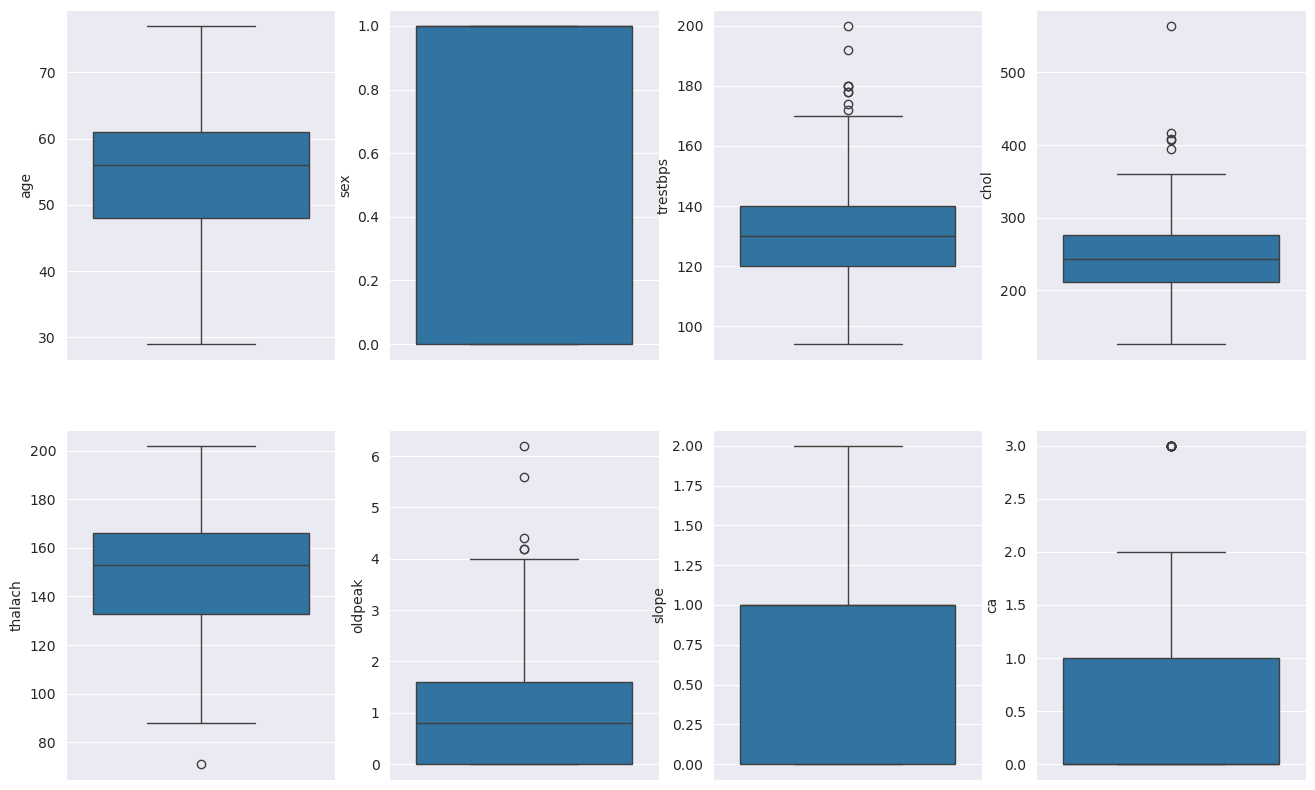

In [21]:
plt.figure(figsize=(16, 10))

for i in range(len(eda_df.columns)):
    plt.subplot(2, 4, i+1)
    sns.boxplot(eda_df[eda_df.columns[i]])
plt.show()

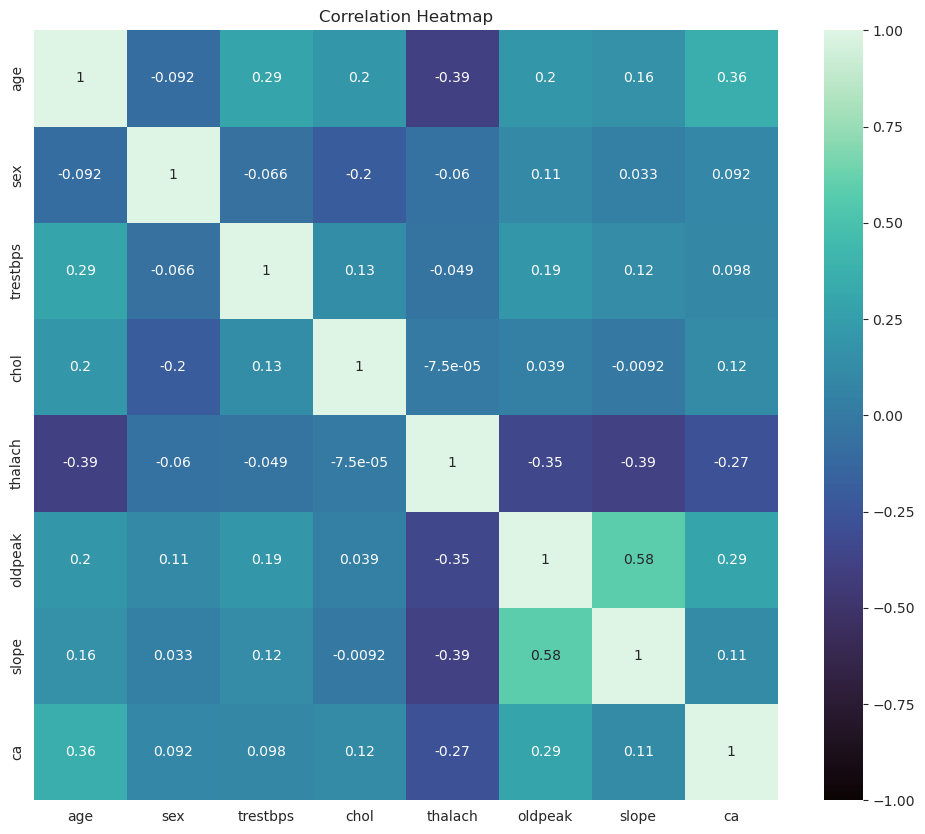

In [22]:
corr = eda_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, vmin=-1.0, cmap='mako')
plt.title('Correlation Heatmap')
plt.show()

We can also visualize the class distribution with a pie chart.

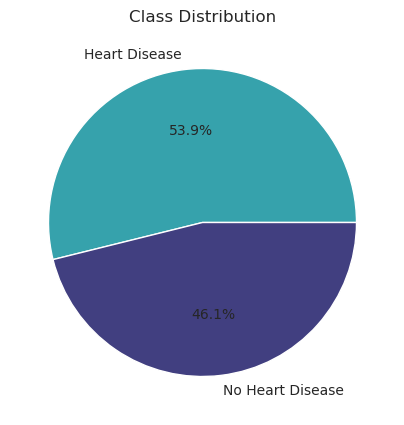

In [28]:
plt.figure(figsize=(5,5))
plt.pie(data['condition'].value_counts(), labels=['Heart Disease', 'No Heart Disease'], autopct = "%.1f%%", colors=['#36a2ac', '#413f80'])
plt.title("Class Distribution")
plt.show()

### Preprocessing

In [29]:
def onehot_encode(df, column_dict):
    df = df.copy()
    for column, prefix in column_dict.items():
        dummies = pd.get_dummies(df[column], prefix=prefix, dtype=int)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

In [37]:
dict(zip(['cp', 'slope', 'thal'], ['cp', 'SL', 'thal']))

{'cp': 'cp', 'slope': 'SL', 'thal': 'thal'}

In [41]:
def preprocess_inputs(df, scaler):
    df = df.copy()

    # One-Hot Encode the nominal features
    nominal_features = ['cp', 'slope', 'thal']
    df = onehot_encode(df, dict(zip(nominal_features, ['CP', 'SL', 'TH'])))
    
    # Split df into X and y
    y = df['condition'].copy()
    X = df.drop('condition', axis=1).copy()

    # Scaling X
    scaler = scaler
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    return X, y 

In [66]:
X, y = preprocess_inputs(data, MinMaxScaler())

In [67]:
X

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,CP_0,CP_1,CP_2,CP_3,SL_0,SL_1,SL_2,TH_0,TH_1,TH_2
0,0.833333,1.0,0.622642,0.246575,1.0,1.0,0.458015,0.0,0.016129,0.333333,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.833333,0.0,0.433962,0.257991,0.0,0.0,0.610687,0.0,0.290323,0.666667,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.770833,0.0,0.528302,0.228311,0.0,0.0,0.328244,0.0,0.419355,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.750000,1.0,0.415094,0.356164,1.0,1.0,0.786260,0.0,0.225806,0.333333,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.729167,1.0,0.150943,0.194064,0.0,1.0,0.557252,1.0,0.290323,0.000000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,0.229167,1.0,0.547170,0.221461,0.0,0.0,0.839695,0.0,0.000000,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
293,0.208333,1.0,0.226415,0.212329,0.0,0.0,0.526718,0.0,0.193548,0.000000,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
294,0.125000,1.0,0.245283,0.164384,0.0,0.0,0.450382,1.0,0.258065,0.000000,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
295,0.125000,0.0,0.415094,0.130137,0.0,0.0,0.847328,0.0,0.225806,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


### Training

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

In [69]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
print("Logistic Regression Accuracy: {:.2f}%".format(lr_model.score(X_test, y_test)*100))

Logistic Regression Accuracy: 85.00%


In [70]:
svm_model = SVC()
svm_model.fit(X_train, y_train)
print("Support Vector Machine Accuracy: {:.2f}%".format(svm_model.score(X_test, y_test)*100))

Support Vector Machine Accuracy: 85.00%


In [72]:
nn_model = MLPClassifier()
nn_model.fit(X_train, y_train)
print("Neural Network Accuracy: {:.2f}%".format(nn_model.score(X_test, y_test)*100))

Neural Network Accuracy: 86.67%


/home/aditya/miniconda3/envs/tfenv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [73]:
y_test.shape

(60,)